<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/dl-book-chapter-2/DL_chapter_2_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.6. И о практике: введение в TensorFlow и Keras


Среди библиотек общего назначения, которые способны строить граф вычислений и проводить автоматическое дифференцирование, долгое время бесспорным лидером была Theano. Однако в ноябре 2015 года Google выпустила (с открытым исходным кодом) библиотеку TensorFlow, предназначенную для того же самого

На конец 2016 Torch считается более эффективной. Пример разделения фронтенда и бекенда: TinyFlow — это библиотека, позволяющая конструировать
граф вычислений на TensorFlow, а обучать его на том же самом Torch.

Тензор -- многомерный массив чисел


## Базовое объявление переменных

In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
w = tf.Variable(
    tf.random_normal([3, 2], mean=0.0, stddev=0.4), 
    name='weights'
)
w

<tf.Variable 'weights:0' shape=(3, 2) dtype=float32_ref>

In [4]:
b = tf.Variable(tf.zeros([2]), name='biases')
b

<tf.Variable 'biases_1:0' shape=(2,) dtype=float32_ref>

In [6]:
w.device, b.device

('', '')

In [0]:
with tf.device('/gpu:0'):
  w = tf.Variable(
      tf.random_normal([3, 2], mean=0.0, stddev=0.4), 
      name='weights'
  )
  b = tf.Variable(tf.zeros([2]), name='biases')

In [8]:
w.device, b.device

('/device:GPU:0', '/device:GPU:0')

In [0]:
# init values
init = tf.global_variables_initializer()

In [0]:
# how to save a session
# saved = saver.save()
# saver.restore('model.ckpt')

## 2 * 3 = 6


In [0]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
output = tf.multiply(x, y)
with tf.Session() as sess:
  result = sess.run(output, feed_dict={x:2, y:3})   # interesting syntax!

In [23]:
result

6

## Суммирование

In [59]:
m = tf.Variable(
    tf.random_normal([10, 100], mean=0.0, stddev=0.4), 
    name='matrix'
)
v = tf.Variable(
    tf.random_normal([1, 100], mean=0.0, stddev=0.4), 
    name='vector'
)
sum_1 = m + v
sum_1

<tf.Tensor 'add_11:0' shape=(10, 100) dtype=float32>

Хочу изобразить результат

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

array_m = m.eval(sess)
array_v = v.eval(sess)

result_sum_1 = sum_1.eval(session=sess)   # :O

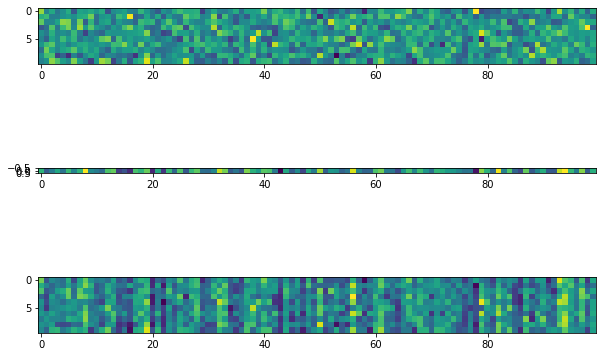

In [62]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=3, figsize=(10, 7))
axes[0].imshow(array_m)
axes[1].imshow(array_v)
axes[2].imshow(result_sum_1)

## Пространства переменных

In [0]:
def linear_transform(vec, shape):
  w = tf.Variable(
      tf.random_normal(shape, mean=0.0, stddev=1.0),
      name='matrix'
  )

  # matrix multiplication
  return tf.matmul(vec, w)


# two runs will create two transform matrices
# result1 = linear_transform(vec1, shape)
# result2 = linear_transform(vec2, shape)

In [0]:
def linear_transform_reproducible(vec, shape):
  with tf.variable_scope('transform'):
    w = tf.get_variable(
        'matrix', shape,
        initializer=tf.random_normal_initializer()
    )
    return tf.matmul(vec, w)

vec1 = tf.Variable(tf.random_normal([1, 5]), name='vec1')
vec2 = tf.Variable(tf.random_normal([1, 5]), name='vec2')
shape = (5, 3)

with tf.variable_scope('transform') as scope:    # ?!
  result1 = linear_transform(vec1, shape)
  scope.reuse_variables()
  result2 = linear_transform(vec2, shape)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

array_1 = result1.eval(session=sess)
array_2 = result2.eval(session=sess)
array_3 = result2.eval(session=sess)

In [81]:
array_1

array([[-0.7866912 , -0.34893978, -1.4939145 ]], dtype=float32)

In [82]:
array_2

array([[-1.0306478, -2.7686694,  1.8277066]], dtype=float32)

In [83]:
array_3

array([[-1.0306478, -2.7686694,  1.8277066]], dtype=float32)

Эм, обещали ошибку, а её нет о_О

И результат вроде бы воспроизводится

# Линейная регрессия

Приближаем функцию $f(x) = kx + b$ для $k = 2$ и $b = 1$. 

$k$ и $b$ -- искомые параметры, которые мы хотим обучить

In [0]:
import numpy as np
import tensorflow as tf

n_samples, batch_size, num_steps = 1000, 100, 20000

X_data = np.random.uniform(1, 10, (n_samples, 1))
y_data = 2 * X_data + 1 + np.random.normal(0, 2, (n_samples, 1))

In [0]:
X = tf.placeholder(tf.float32, shape=(batch_size, 1))
y = tf.placeholder(tf.float32, shape=(batch_size, 1))

In [0]:
with tf.variable_scope('linear-regression'):
  k = tf.Variable(tf.random_normal((1, 1)), name='slope')
  b = tf.Variable(tf.zeros((1,)), name='bias')

y_pred = tf.matmul(X, k) + b
loss = tf.reduce_sum((y - y_pred) ** 2)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(loss)

In [95]:
display_step = 100
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_steps):
    # form mini-batch
    indices = np.random.choice(n_samples, batch_size)
    X_batch, y_batch = X_data[indices], y_data[indices]

    # run
    _, loss_val, k_val, b_val = sess.run(
        [optimizer, loss, k, b],
        feed_dict={X: X_batch, y: y_batch}
    )

    # print results
    if (i + 1) % display_step == 0:
      print('Epoch {}: loss = {:.8f}, k = {:.4f}, b = {:.4f}'.format(
          i + 1, loss_val, k_val[0][0], b_val[0]
      ))

Epoch 100: loss = 421.36270142, k = 2.0937, b = 0.5002
Epoch 200: loss = 334.00466919, k = 2.0332, b = 0.6174
Epoch 300: loss = 335.55249023, k = 2.0309, b = 0.7152
Epoch 400: loss = 407.35946655, k = 2.0200, b = 0.7785
Epoch 500: loss = 381.70211792, k = 2.0170, b = 0.8198
Epoch 600: loss = 324.88937378, k = 2.0377, b = 0.8543
Epoch 700: loss = 300.89495850, k = 1.9952, b = 0.8962
Epoch 800: loss = 431.33248901, k = 2.0169, b = 0.9530
Epoch 900: loss = 353.72406006, k = 2.0017, b = 0.9468
Epoch 1000: loss = 328.98483276, k = 2.0278, b = 0.9553
Epoch 1100: loss = 283.53033447, k = 2.0240, b = 0.9385
Epoch 1200: loss = 321.68170166, k = 1.9751, b = 0.9298
Epoch 1300: loss = 413.78790283, k = 1.9903, b = 0.9397
Epoch 1400: loss = 372.58465576, k = 1.9940, b = 0.9344
Epoch 1500: loss = 403.03509521, k = 1.9707, b = 0.9243
Epoch 1600: loss = 454.09646606, k = 2.0246, b = 0.9217
Epoch 1700: loss = 438.88409424, k = 1.9672, b = 0.9154
Epoch 1800: loss = 310.84017944, k = 2.0416, b = 0.8970
E

# WOW! Работает!